In [3]:
from nb_UTA import *

ModuleNotFoundError: No module named 'nb_UTA'

I couldn't find what the `nb_UTA` module is or how to install it, so I sort of gave up.

In [2]:
class Promethee(nn.Module):
    def __init__(self, criteria_nr, hidden_nr, **kwargs):
        super().__init__()
        self.uta = Uta(criteria_nr, hidden_nr, **kwargs)
        self.criteria_nr = criteria_nr
        self.thresholdLayer = ThresholdLayer()

    def SetSlope(self, val):
        return self.uta.SetSlope(val)

    def forward(self, x, *args):
        out = []
        for i in range(len(x)):
            out.append(self.uta(F.relu(x[i] - x)))
        out = torch.cat(out, 1)
        zero_input = (
            torch.FloatTensor(self.criteria_nr).zero_().view(1, 1, -1).to(out.device)
        )
        self.zero = self.uta(zero_input)
        self.one = self.uta(zero_input + 1)

        out = (out - self.zero) / (self.one - self.zero)

        positive_flow = out.sum(0) / (len(x) - 1)
        negative_flow = out.sum(1) / (len(x) - 1)
        total_flow = positive_flow - negative_flow
        return self.thresholdLayer(total_flow).reshape(-1, 1)

In [3]:
path = "../data/lectures-evaluation.csv"
data = pd.read_csv(path, header=None)
target_map = {0: 0, 1: 0, 2: 0, 3: 1, 4: 1}
criteria_nr = 4
data_input = data.iloc[:, :criteria_nr]
data_target = data[criteria_nr].apply(lambda x: target_map[x])

data_input = data_input.values.reshape(-1, 1, criteria_nr)

X_train, X_test, y_train, y_test = train_test_split(
    data_input, data_target.values, test_size=0.2, random_state=1234
)

In [4]:
train_dataloader = CreateDataLoader(X_train, y_train)
test_dataloader = CreateDataLoader(X_test, y_test)

In [7]:
PATH = "promethee.pt2"

In [8]:
model = Promethee(criteria_nr, 20)

In [9]:
acc, acc_test, auc, auc_test = Train(model, train_dataloader, test_dataloader, PATH)

print("Accuracy train:\t%.2f%%" % (acc * 100.0))
print("AUC train: \t%.2f%%" % (acc_test * 100.0))
print()
print("Accuracy test:\t%.2f%%" % (auc * 100.0))
print("AUC test: \t%.2f%%" % (auc_test * 100.0))


100%|ââââââââââââââââââââââââââââââââââââââââ| 200/200 [14:23<00:00,  4.32s/it]

Accuracy train:	81.62%
AUC train: 	80.50%

Accuracy test:	81.69%
AUC test: 	77.93%


In [10]:
checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

In [11]:
def getSimpleInput(val):
    return (
        torch.FloatTensor([[val] * criteria_nr] + [[0.0] * criteria_nr])
        .view(2, 1, -1)
        .cpu()
    )


hook = Hook(model.uta.criterionLayerCombine, append_output)
xs = []
with torch.no_grad():
    for i in range(201):
        val = (i - 100) / 100.0
        x = getSimpleInput(val)
        xs.append(val)
        model(x)

outs = np.array(torch.stack(hook.stats[::4])[:, 1].detach().cpu())
outs = outs * model.uta.sum_layer.weight.detach().numpy()[0]

outs = outs / outs[-1].sum()

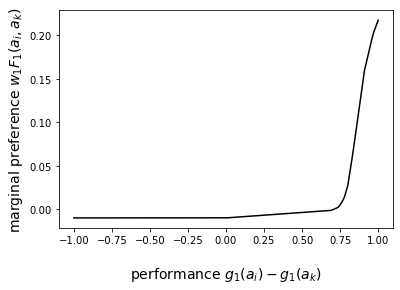

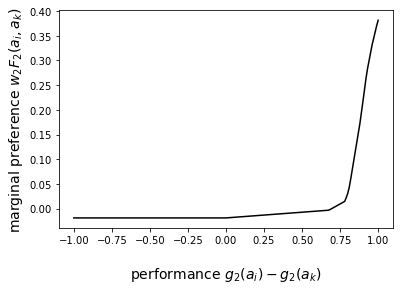

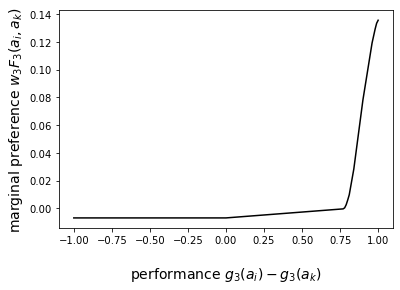

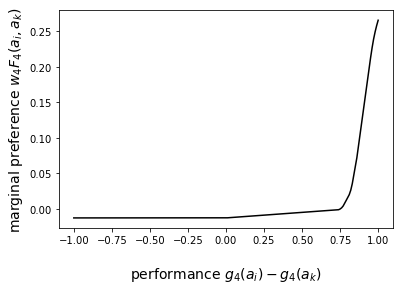

In [12]:
for i in range(outs.shape[1]):
    plt.plot(xs, outs[:, i], color="black")
    plt.ylabel("marginal preference $w_{0} F_{0}(a_i,a_k)$".format(i + 1), fontsize=14)
    plt.xlabel(
        "performance $g_{0}(a_i) - g_{0}(a_k)$".format(i + 1), fontsize=14, labelpad=20
    )

    plt.show()